#DT2470 Lab 02: Synchronization and rhythm

by Andre Holzapfel

In this lab you will choose to **either** do exercises regarding synchronization (chapter 3), **or** rhythm and tempo processing (chapter 6). We agree that doing both would be too much work (for this year), but you will have the code for the solutions for both anyway!

Again, you can use whatever software you want for your own implementation, but I use python in my explanations, and two external libraries in python need to be used in this Lab. Just as Bob, I am basically learning Python by working on this lab, so excuse my bad programming. (I am a bad programmer independent of language, anyway.)

Your task is to reproduce all shown figures with your code (or show the equivalent plots for your own audio files, if you use different ones). Also, provide short answers to the questions in the text.

# 1. Synchronisation

Complete the tasks in this part, if you want to focus on the synchronisation (but have a look at the rhythm part below before you decide!).

## Part 1.1 Warming up

Choose two music sound files that can be considered as interpretations of the same "tune". In my example I used the cmajor_piano.wav and Cmajor_sung.wav, where a C-major scale is performed, once on piano and once sung. For the beginning, choose some excerpts, and not complete pieces, in order to get started.

Read the sound files to a numpy array, and plot the two waveforms. (You did that in Lab 1 too).

Below the waveform I get for the piano file: <br>
![waveform](https://drive.google.com/uc?id=1nt5lUZ1IWO8nWDx2mTdddz2pI9CuBfTq)


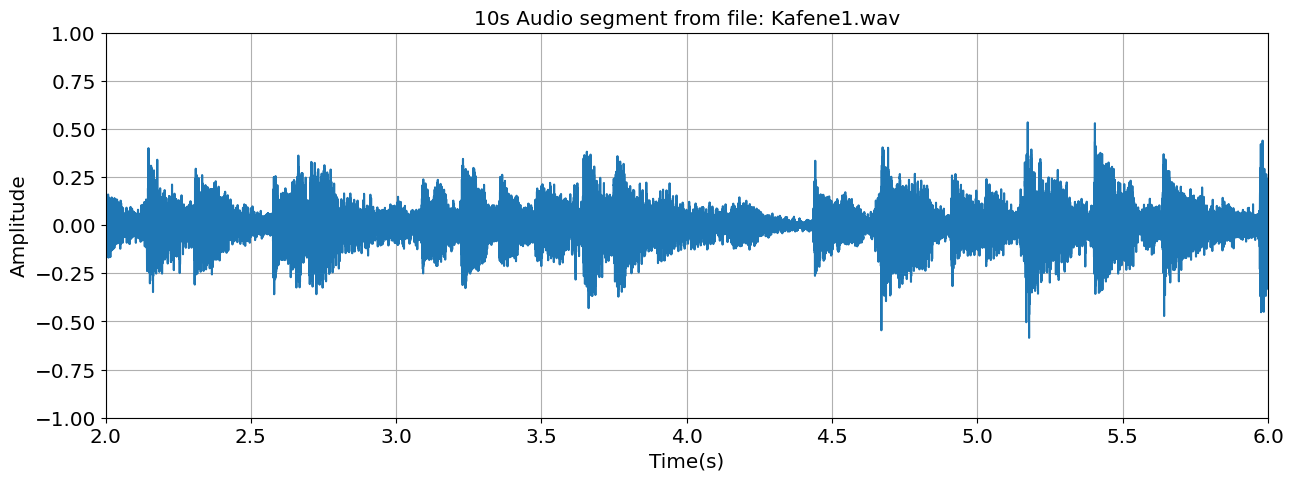

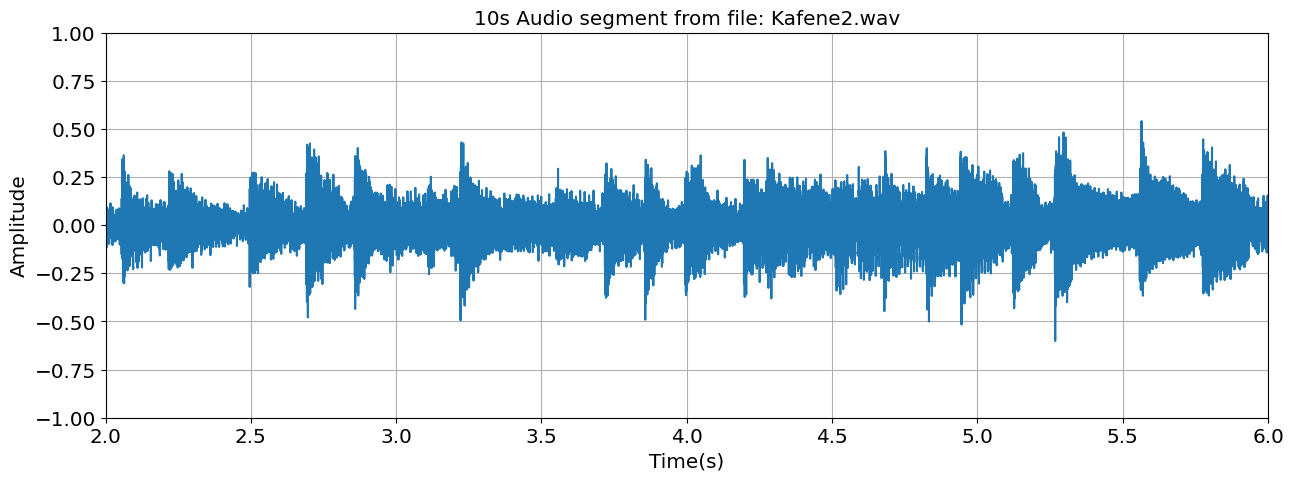

In [35]:
# Now we plot the entire audio file
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, fft
import librosa

def plot_waveform(filename):
    # The following makes the plot look nice
    params = {'legend.fontsize': 'x-large',
            'figure.figsize': (15, 5),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)

    # Import the audio file
    starting_time = 2
    duration = 4 #s

    sound = AudioSegment.from_file(filename, format="wav")
    sound = sound.split_to_mono()[0]
    scaling_factor = 1.0 / sound.max #normalization


    # Get sample as a numpy array
    samples = np.array(sound[starting_time*1000:(starting_time+duration)*1000].get_array_of_samples())*scaling_factor

    # Get time values for x-axis
    time = np.linspace(starting_time, starting_time+duration, num=len(samples))

    # Plot the signal
    plt.plot(time, samples)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title("10s Audio segment from file: "+filename)
    plt.grid(True)
    plt.xlim(2, 6)
    plt.ylim(-1, 1)
    plt.show()

plot_waveform("Kafene1.wav")
plot_waveform("Kafene2.wav")

## Part 1.2 Compute the spectral magnitude

For both signals compute a Short-time Fourier transform (STFT), and plot their magnitude spectra (as in equation 3.1. Use the code from Lab 1 as starting point). Note: Since you are focusing on tonal content in the Chroma features, use a long window (about 100ms).

The magnitude spectrum for the piano example is shown below. 

Question: why do we see so few high-frequency components? (Hint: in lab 1 you plotted db magnitude spectra).

![](https://drive.google.com/uc?id=1_fEgRgIG0pPzCiNa6Pqz5lDfk-vfGloX)

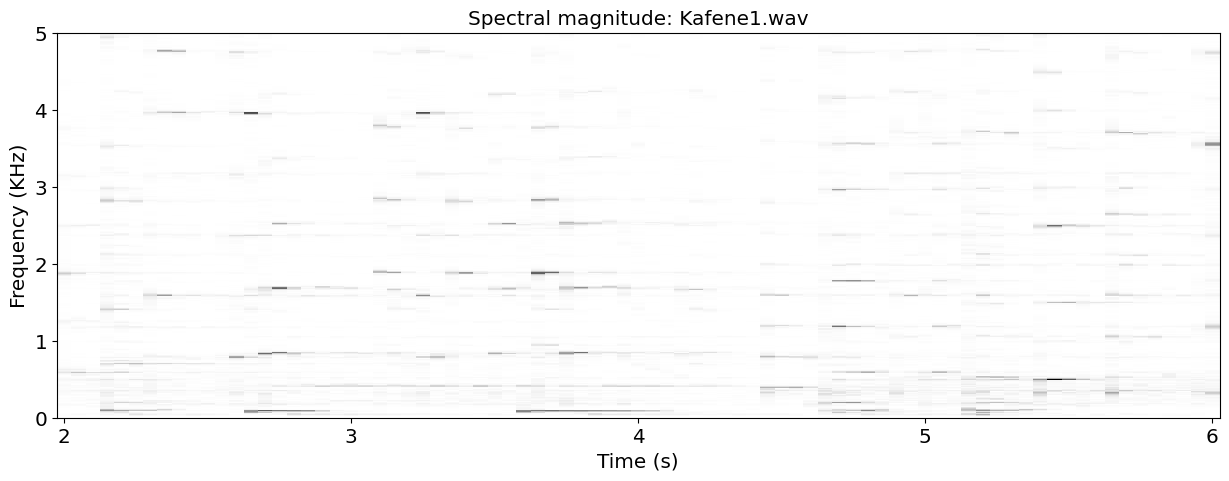

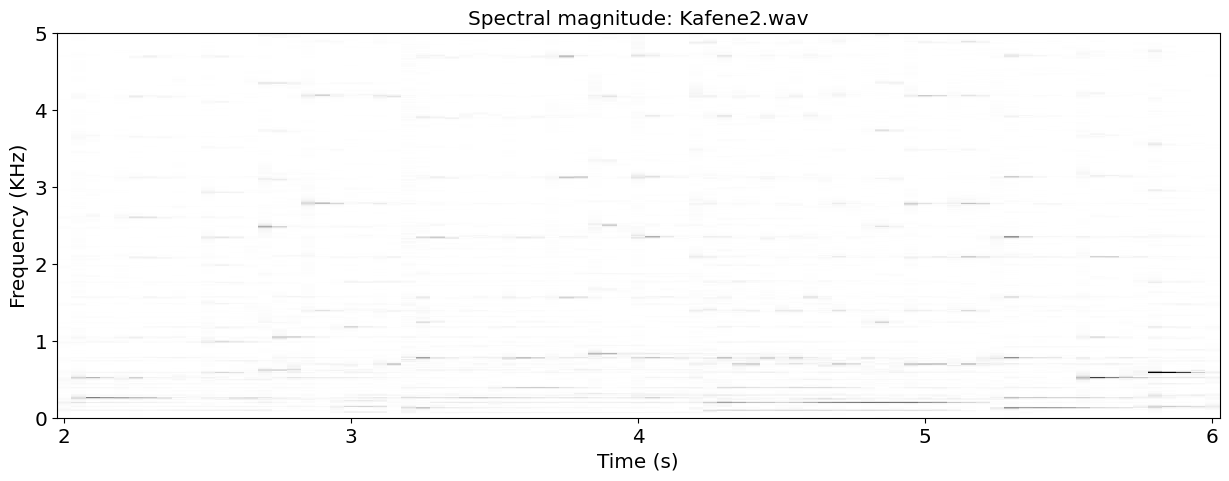

In [36]:
import librosa

def get_samples(filename):
    # Import the audio file
    starting_time = 2
    duration = 4 #s

    sound = AudioSegment.from_file(filename, format="wav")
    sound = sound.split_to_mono()[0]
    scaling_factor = 1.0 / sound.max #normalization
    # Get sample as a numpy array
    samples = np.array(sound[starting_time*1000:(starting_time+duration)*1000].get_array_of_samples())*scaling_factor
    sample_rate = sound.frame_rate
    return samples, sample_rate

samples1, sample_rate1 = get_samples("Kafene1.wav")
samples2, sample_rate2 = get_samples("Kafene2.wav")


# Plots the stft spectrogram of an audio segment
def plot_stft_from_audio_segment(audio_segment, window_type, window_size, hop_size, fft_sample_size, sample_rate, plot_title):
    overlapping_samples = sample_rate*(window_size - hop_size)
    
    frequency, time, stft_matrix = signal.stft(
        audio_segment, 
        fs=sample_rate, 
        window=window_type, 
        nperseg=int(window_size*sample_rate),
        #nfft=fft_sample_size,
        noverlap=overlapping_samples)

    # Convert to kHz
    frequency = frequency / 1000

    # Get stft amplitude and convert to dB
    stft_amplitude = np.abs(stft_matrix)
    #stft_db = librosa.amplitude_to_db(stft_amplitude, ref=np.max)

    # Plot the spectrogram
    plt.title(plot_title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (KHz)')
    plt.ylim((0,5)) # limit to 5kHz the frequency axis
    # Customize the x-axis ticks and labels
    x_ticks_positions = np.arange(0, 11)
    x_ticks_labels = [str(i) for i in range(2, 13)]
    plt.xticks(x_ticks_positions, x_ticks_labels)
    plt.pcolormesh(time, frequency, stft_amplitude, cmap="Greys")
    #plt.colorbar(format='%+2.0f dB')
    plt.show()
    return frequency*1000, time, stft_amplitude

# Plot the stft spectrogram of the first 10s with the given parameters

freq1, time1, stft_db1 = plot_stft_from_audio_segment(
    samples1, 
    window_type='hann', 
    window_size=0.10,
    hop_size=0.05,
    fft_sample_size=0.15*sample_rate1,
    sample_rate=sample_rate1, 
    plot_title="Spectral magnitude: Kafene1.wav"
    )

freq2, time2, stft_db2 =plot_stft_from_audio_segment(
    samples2, 
    window_type='hann', 
    window_size=0.10,
    hop_size=0.05,
    fft_sample_size=0.15*sample_rate2,
    sample_rate=sample_rate2, 
    plot_title="Spectral magnitude: Kafene2.wav"
    )



## Part 1.3 Compute a log-frequency spectrogram

Now, transform the linear frequency axis into a logarithmic one (equation 3.4), and plot the resulting log-frequency spectra for both signals.

Hint: you need to assign the frequencies of the STFT coefficients to the desired pitch bins of the 12-tone resolution (equations 3.2 and 3.3, and the related text in the book help). Unless you are a good numpy programmer (I am not), you will need some loop in that code...

My piano log-f spectrogram looks as shown below.

Question: why do the low-frequency regions look so spread-out and smeary?

![](https://drive.google.com/uc?id=1pxHK7CVEX438DB4BAASGEiU3Qi-hw3Sc)



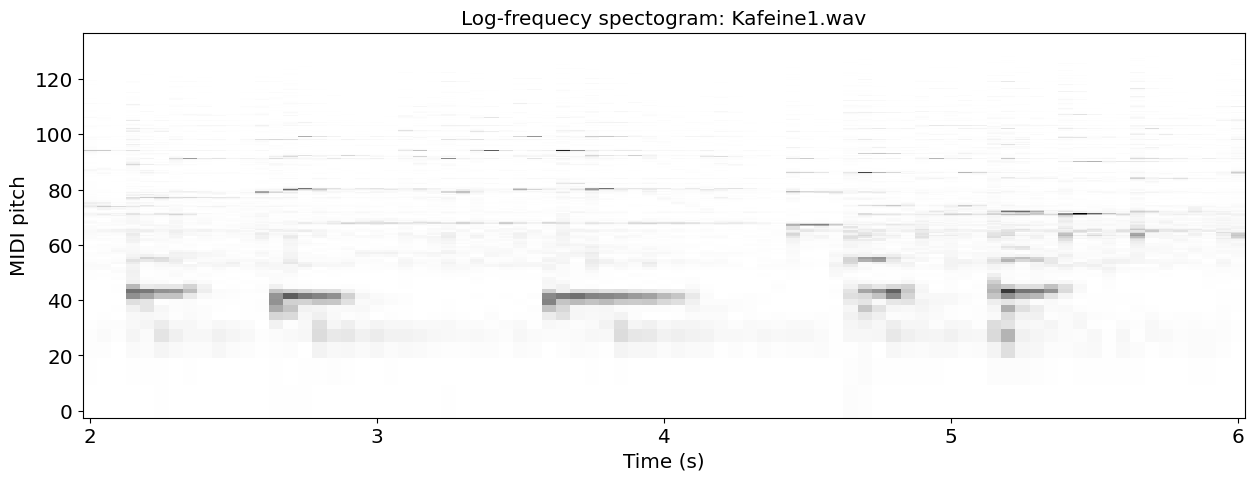

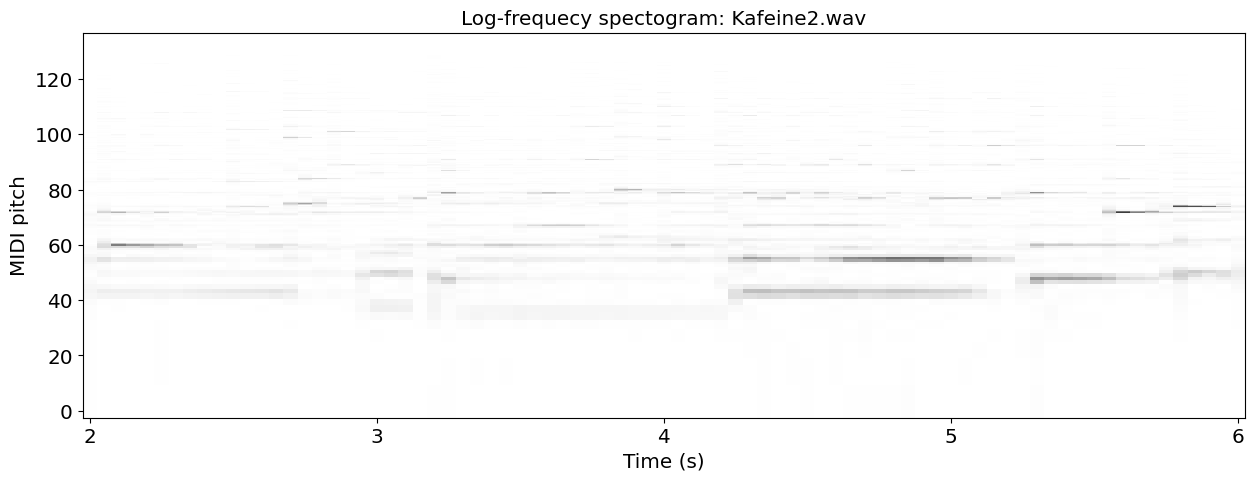

In [37]:
freq1 = np.delete(freq1, 0)
freq2 = np.delete(freq2, 0)
stft_db1 = np.delete(stft_db1, 0, axis=0)
stft_db2 = np.delete(stft_db2, 0, axis=0)
freq1_log = (12 * np.log2(freq1 / 440)) + 69
freq2_log = (12 * np.log2(freq2 / 440)) + 69

# Plot the spectrogram
plt.title("Log-frequecy spectogram: Kafeine1.wav")
plt.xlabel('Time (s)')
plt.ylabel('MIDI pitch')
# Customize the x-axis ticks and labels
x_ticks_positions = np.arange(0, 11)
x_ticks_labels = [str(i) for i in range(2, 13)]
plt.xticks(x_ticks_positions, x_ticks_labels)
plt.pcolormesh(time1, freq1_log, stft_db1,cmap="Greys")
#plt.colorbar(format='%+2.0f dB')
plt.show()

# Plot the spectrogram
plt.title("Log-frequecy spectogram: Kafeine2.wav")
plt.xlabel('Time (s)')
plt.ylabel('MIDI pitch')
# Customize the x-axis ticks and labels
x_ticks_positions = np.arange(0, 11)
x_ticks_labels = [str(i) for i in range(2, 13)]
plt.xticks(x_ticks_positions, x_ticks_labels)
plt.pcolormesh(time2, freq2_log, stft_db2,cmap="Greys")
#plt.colorbar(format='%+2.0f dB')
plt.show()


In [38]:
def groupFreq(p_min, p_max, frequency, stft_db):
    out = []
    for i in range(p_min,p_max):
        mask = (frequency >= i-0.5) & (frequency<i+0.5)
        masked_stft = stft_db[mask]
        grouped_values = np.sum(masked_stft,axis=0)
        out.append(grouped_values)
    return np.array(out)

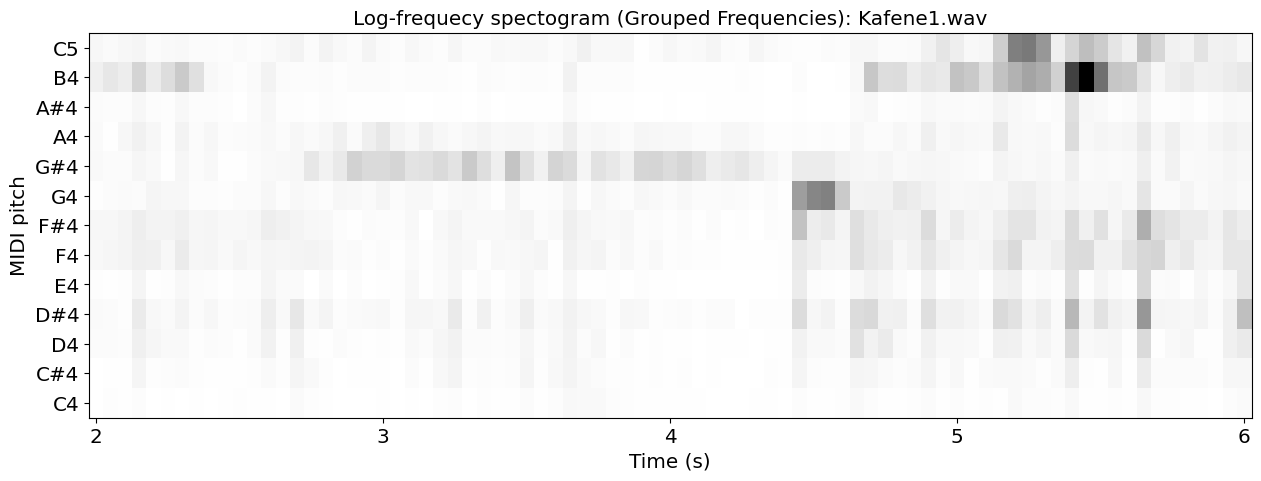

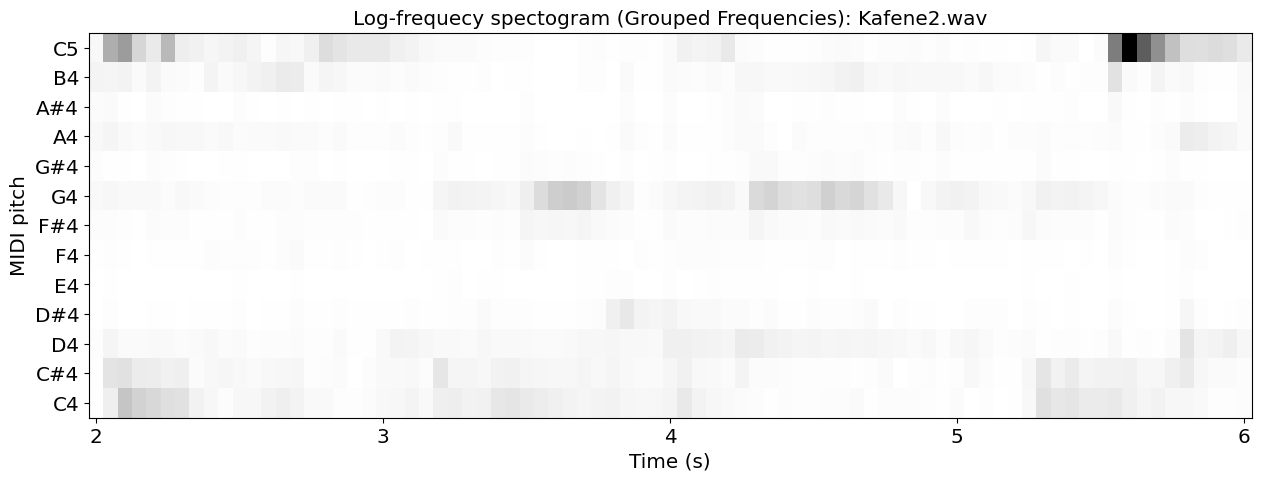

In [39]:
pitch_min = 60
pitch_max = 73
mask1 = (freq1_log > 59.5) & (freq1_log < 72.5)
mask2 = (freq2_log > 59.5) & (freq2_log < 72.5)

freq1_log_masked = freq1_log[mask1]
stft_db1_masked = stft_db1[mask1]
freq2_log_masked = freq2_log[mask2]
stft_db2_masked = stft_db2[mask2]

freq = np.array([i for i in range(pitch_min, pitch_max)])
grouped_stft1 = groupFreq(pitch_min, pitch_max, freq1_log_masked,stft_db1_masked)
grouped_stft2 = groupFreq(pitch_min, pitch_max, freq2_log_masked,stft_db2_masked)

# Plot the spectrogram
plt.title("Log-frequecy spectogram (Grouped Frequencies): Kafene1.wav")
plt.xlabel('Time (s)')
plt.ylabel('MIDI pitch')
x_ticks_positions = np.arange(0, 11)
x_ticks_labels = [str(i) for i in range(2, 13)]
plt.xticks(x_ticks_positions, x_ticks_labels)
y_ticks_positions = np.arange(pitch_min, pitch_max)
y_ticks_labels = ["C4", "C#4", "D4", "D#4", "E4", "F4", "F#4", "G4", "G#4", "A4", "A#4", "B4", "C5"]
plt.yticks(y_ticks_positions, y_ticks_labels)
plt.pcolormesh(time1, freq, grouped_stft1,cmap="Greys")
plt.show()

# Plot the spectrogram
plt.title("Log-frequecy spectogram (Grouped Frequencies): Kafene2.wav")
plt.xlabel('Time (s)')
plt.ylabel('MIDI pitch')
x_ticks_positions = np.arange(0, 11)
x_ticks_labels = [str(i) for i in range(2, 13)]
plt.xticks(x_ticks_positions, x_ticks_labels)
y_ticks_positions = np.arange(pitch_min, pitch_max)
y_ticks_labels = ["C4", "C#4", "D4", "D#4", "E4", "F4", "F#4", "G4", "G#4", "A4", "A#4", "B4", "C5"]
plt.yticks(y_ticks_positions, y_ticks_labels)
plt.pcolormesh(time2, freq, grouped_stft2,cmap="Greys")
plt.show()

## Compute the chromagram

The chromagram is a feature that captures well harmonic and melodic development in a sound file. You will compute these features, to apply a synchronization (DTW) algorithm to them.



1.   Compute the chromagram according to equation 3.6

![](https://drive.google.com/uc?id=1Hj26wZ2WHufe1DkZqZoFrJ06kS7y8msS)

2.   Apply logarithmic compression to the chromagram. This will be your input feature for the DTW (my example uses gamma=100).

![](https://drive.google.com/uc?id=1eX8WhSmn6XxI8sIXxfRxdnssSrf2kICT)

In [40]:
def groupArm(frequency, stft_db):
    out = []
    for i in range(12):
        mask = (frequency % 12 >= i-0.5) & (frequency % 12 <i+0.5)
        masked_stft = stft_db[mask]
        grouped_values = np.sum(masked_stft,axis=0)
        out.append(grouped_values)
    return np.array(out)

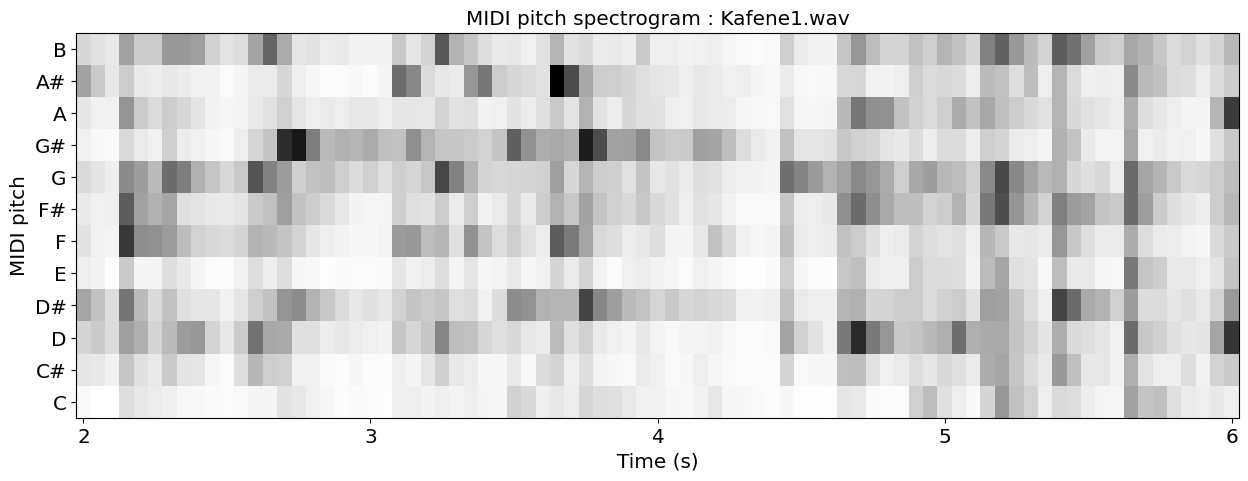

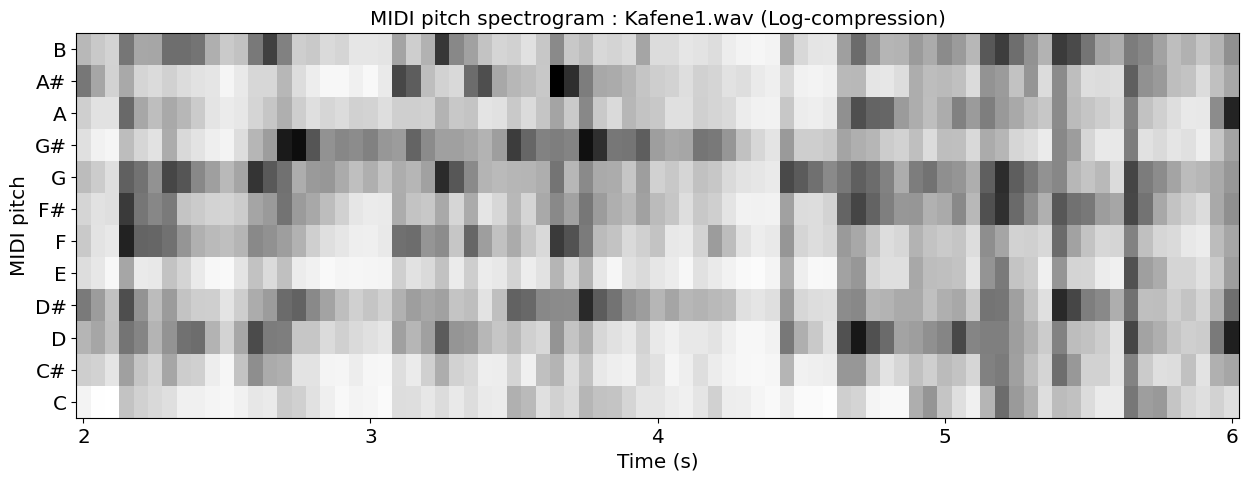

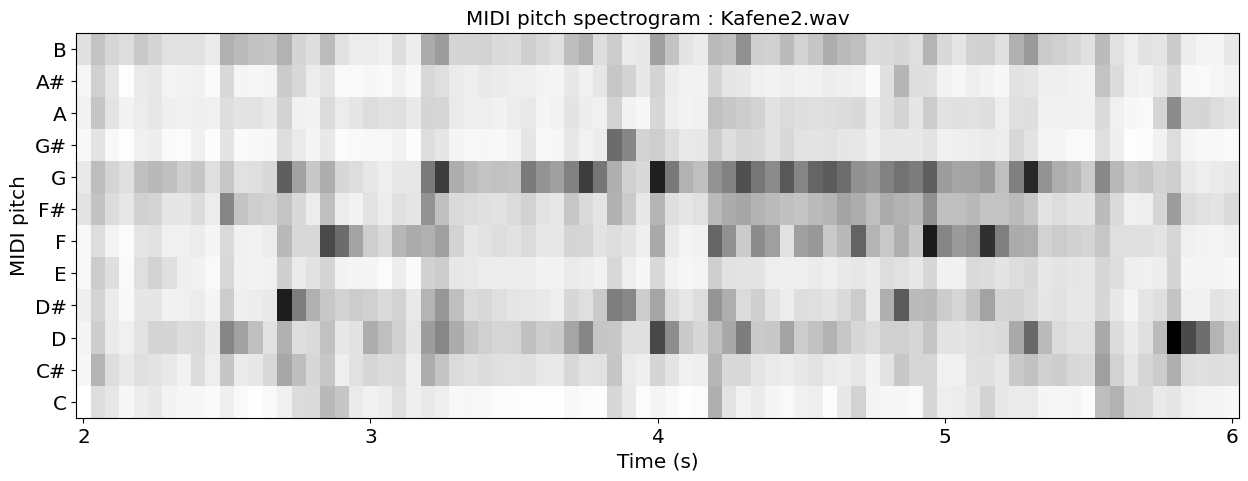

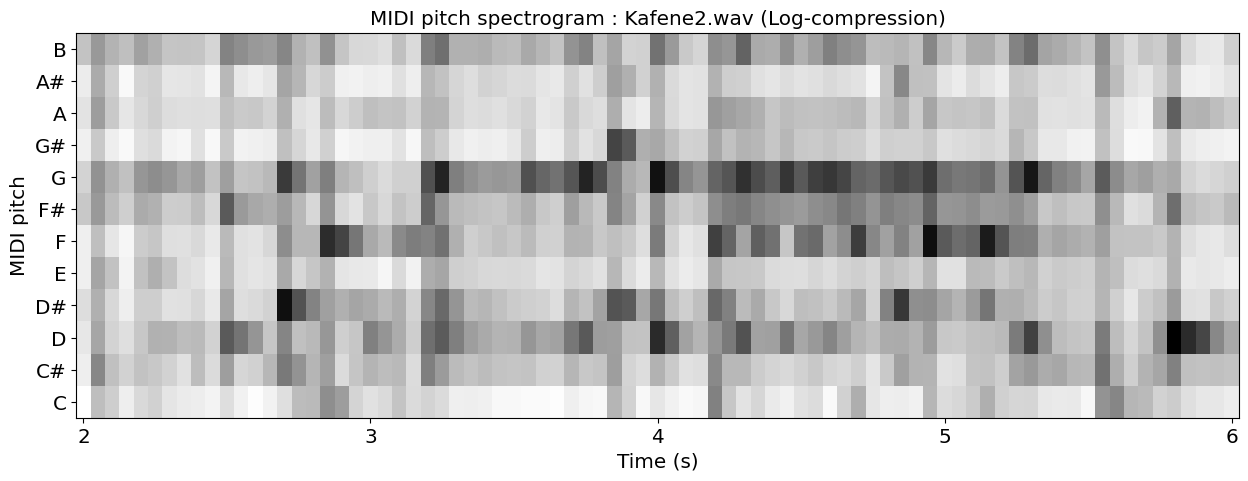

In [41]:
import math

pitch_min = 0
pitch_max = 127
mask1 = (freq1_log >= 0) & (freq1_log < 127.5)
mask2 = (freq2_log >= 0) & (freq2_log < 127.5)

freq1_log_masked = freq1_log[mask1]
stft_db1_masked = stft_db1[mask1]
freq2_log_masked = freq2_log[mask2]
stft_db2_masked = stft_db2[mask2]

freq = np.array([i for i in range(12)])
grouped_stft1 = groupArm(freq1_log_masked,stft_db1_masked)
grouped_stft2 = groupArm(freq2_log_masked,stft_db2_masked)

gamma = 10
logCompresser = lambda t: np.log(1 + gamma * np.abs(t))

def plot_spectrogram(time, freq, dataToPlot, xAxisLabel, yAxisLabel, title):
  # Plot the spectrogram
  plt.title(title)
  plt.xlabel(xAxisLabel)
  plt.ylabel(yAxisLabel)
  x_ticks_positions = np.arange(0, 11)
  x_ticks_labels = [str(i) for i in range(2, 13)]
  plt.xticks(x_ticks_positions, x_ticks_labels)
  y_ticks_positions = np.arange(0, 12)
  y_ticks_labels = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
  plt.yticks(y_ticks_positions, y_ticks_labels)
  plt.pcolormesh(time, freq, dataToPlot,cmap='gray_r')
  plt.show()

plot_spectrogram(time1, freq, grouped_stft1, 'Time (s)', 'MIDI pitch', 'MIDI pitch spectrogram : Kafene1.wav')
plot_spectrogram(time1, freq, logCompresser(grouped_stft1), 'Time (s)', 'MIDI pitch', 'MIDI pitch spectrogram : Kafene1.wav (Log-compression)')
plot_spectrogram(time2, freq, grouped_stft2, 'Time (s)', 'MIDI pitch', 'MIDI pitch spectrogram : Kafene2.wav')
plot_spectrogram(time2, freq, logCompresser(grouped_stft2), 'Time (s)', 'MIDI pitch', 'MIDI pitch spectrogram : Kafene2.wav (Log-compression)')


## Part 1.4 Compute the synchronization

To this end, you will use the DTW as provided by the librosa library. You can see how to use it in the following code:

https://librosa.github.io/librosa_gallery/auto_examples/plot_music_sync

You can use your two computed chromagrams as inputs X and Y to this function, as they are. Compute the synchronization, and plot the path over the obtained cost matrix D. Your code should start somehow like:

Text(0.5, 1.0, 'Warping Path on Acc. Cost Matrix $D$')

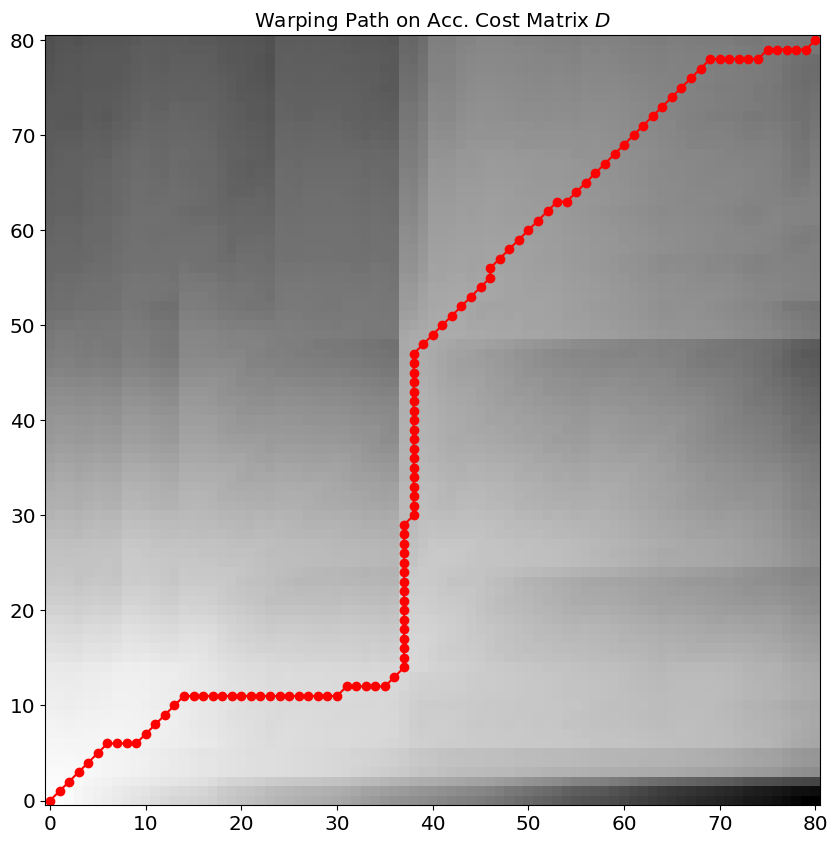

In [42]:
import librosa
import librosa.display

D, wp = librosa.sequence.dtw(X=logCompresser(grouped_stft1), Y=logCompresser(grouped_stft2), metric='cosine')
hop_size = 0.15 * sample_rate1
n_fft = 0.15 * sample_rate1
wp_s = np.asarray(wp) * hop_size / n_fft

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
#librosa.display.specshow(D, x_axis='time', y_axis='time',
 #                        cmap='gray_r', hop_length=hop_size1)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
#plt.colorbar()

## Part 1.5 Compute the same alignment using the chroma features from librosa

OK, we went by the course book when computing the features above. Now let us use the librosa library, to compare with our implementation.

To this end, you can copy/paste and edit the code from the librosa example provided above, and compute the plots!

The chroma features look less noisy for me, probably because I used the logarithmic compression with a bad parameter. Note that the book says that all the parameters need to be adapted with care (which some people might call feature engineering).



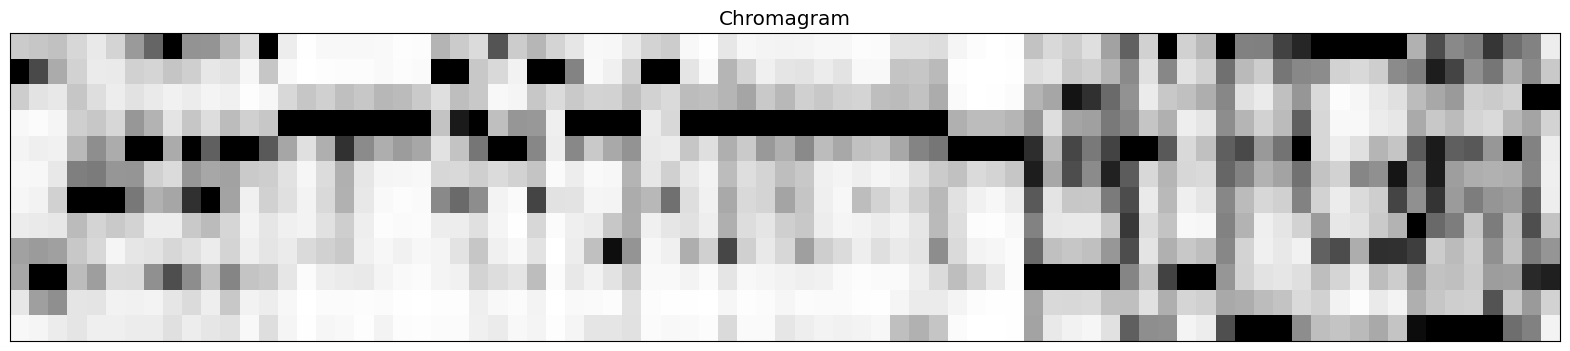

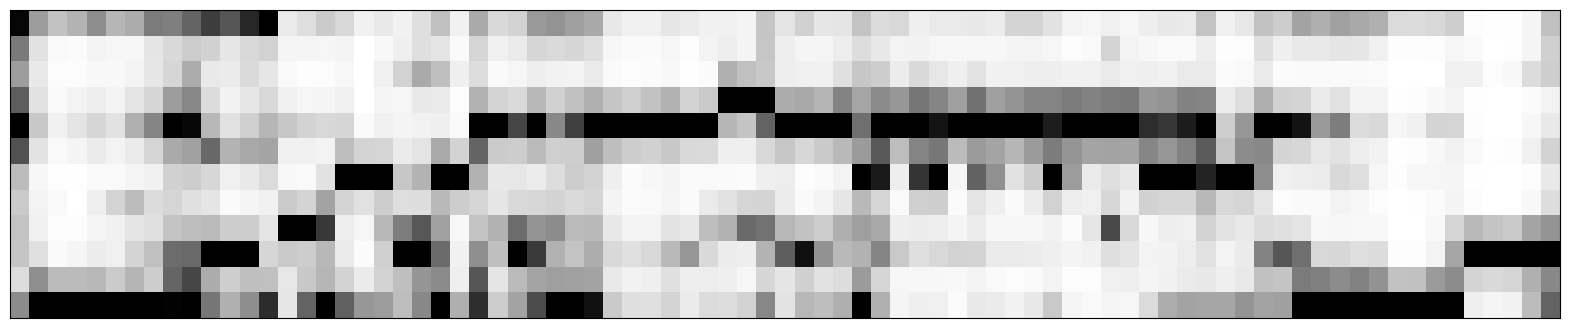

In [43]:
n_fft1 = int(0.10*sample_rate1)

hop_size1 = n_fft1
chroma_stft1 = librosa.feature.chroma_stft(y=samples1, sr=sample_rate1, n_fft=n_fft1, win_length=n_fft1, hop_length=int(hop_size1/2))

plt.figure(figsize=(20, 4))
librosa.display.specshow(chroma_stft1, cmap='gray_r')


# Plot the spectrogram
plt.title("Chromagram")
plt.show()

n_fft2 = int(0.10*sample_rate2)
hop_size2 = n_fft2

chroma_stft2 = librosa.feature.chroma_stft(y=samples2, sr=sample_rate2, n_fft=n_fft2,hop_length=int(hop_size2/2))

plt.figure(figsize=(20, 4))
librosa.display.specshow(chroma_stft2, cmap='gray_r')

Text(0.5, 1.0, 'Warping Path on Acc. Cost Matrix $D$')

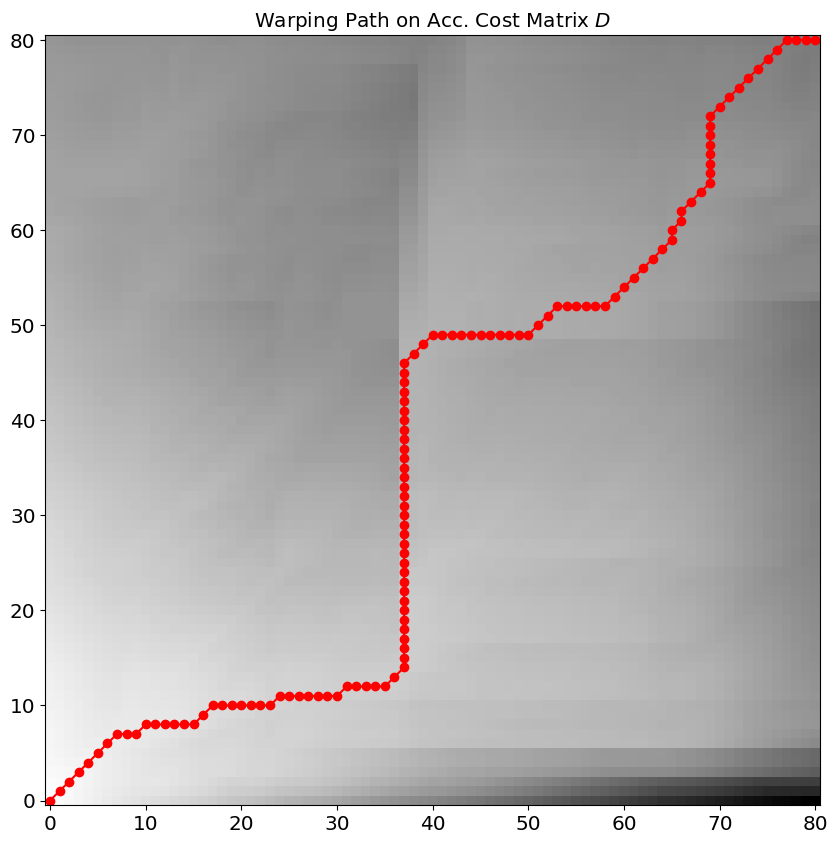

In [44]:
import librosa
import librosa.display

D, wp = librosa.sequence.dtw(X=chroma_stft1, Y=chroma_stft2, metric='cosine')
wp_s = np.asarray(wp) * hop_size1 / n_fft1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
#librosa.display.specshow(D, x_axis='time', y_axis='time',
 #                        cmap='gray_r', hop_length=hop_size1)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
#plt.colorbar()

[Text(-5.0, 0, ''),
 Text(0.0, 0, ''),
 Text(5.0, 0, ''),
 Text(10.0, 0, ''),
 Text(15.0, 0, ''),
 Text(20.0, 0, ''),
 Text(25.0, 0, ''),
 Text(30.0, 0, ''),
 Text(35.0, 0, ''),
 Text(40.0, 0, ''),
 Text(45.0, 0, '')]

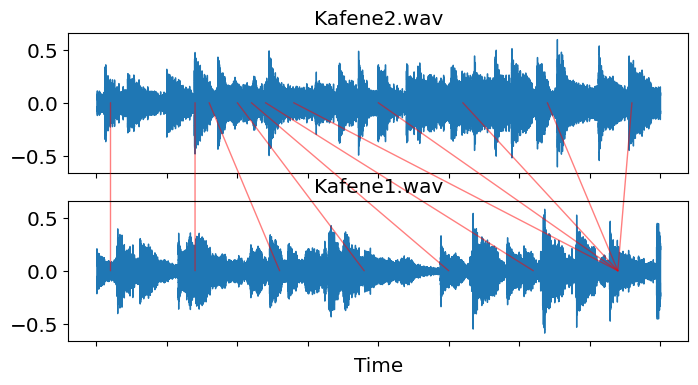

In [45]:
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import *
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8,4))

# Plot x_2
librosa.display.waveshow(samples1, sr=n_fft1, ax=ax2)
ax2.set(title='Kafene1.wav')

# Plot x_1
librosa.display.waveshow(samples2, sr=n_fft2, ax=ax1)
ax1.set(title='Kafene2.wav')
ax1.label_outer()


n_arrows = 20
for tp1, tp2 in wp_s[::len(wp_s)//n_arrows]:
    # Create a connection patch between the aligned time points
    # in each subplot
    con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='-',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)
plt.gca().axes.xaxis.set_ticklabels([])

## Part 1.6 Last task: conclude, explore



1.   Compare the alignment obtained from "your" features with those using the librosa features, are they different? If yes, why do you think?
2.   Replace the two simple sound files by two complete songs. You can use the Kafene1 and Kafene2 files in the shared folder, or some other song you like more. Compute the alignment, using the librosa features and provide a plot of the alignment curve. Did it work?
3. Find two files where the alignment does not work, and explain why. Note: this can be e.g. because the two versions differ in form (e.g. Refrain repeated in one version), tuning, or instrumentation. Also: the chroma features work best for harmonic instruments, and for western-tonal music.



### ANSWERS
1. Overall the path extracted from our features looks quite similar to the other computed with librosa: our features extraction looks consistent with the work done by librosa. There are some small differences which could be related to the choice of the window size and the overlap which were a bit different.
2. We did the same work with the entire Kafene1 and Kafene2 and it seems to work in the correct way: the two song are similar and the pattern is almost linear.

In [46]:
sound = AudioSegment.from_file("Kafene1.wav", format="wav")
sound = sound.split_to_mono()[0]
scaling_factor = 1.0 / sound.max #normalization
samples1 = np.array(sound.get_array_of_samples())*scaling_factor
sample_rate1 = sound.frame_rate

sound = AudioSegment.from_file("Kafene2.wav", format="wav")
sound = sound.split_to_mono()[0]
scaling_factor = 1.0 / sound.max #normalization
samples2 = np.array(sound.get_array_of_samples())*scaling_factor
sample_rate2 = sound.frame_rate

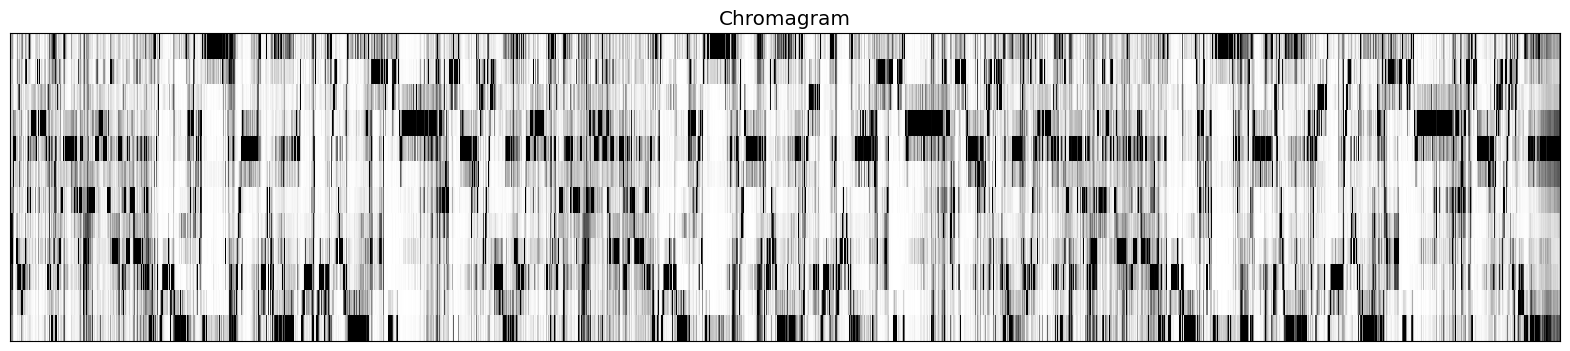

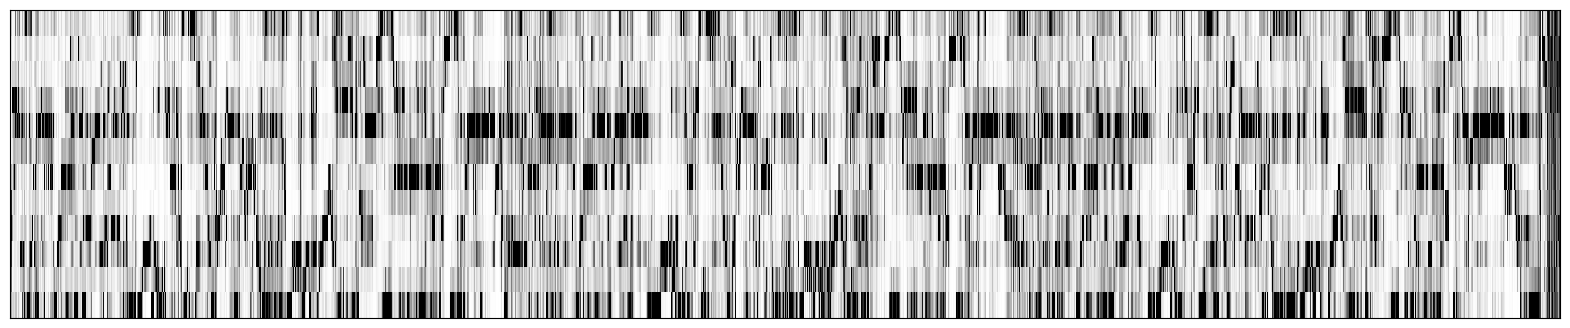

In [47]:
n_fft1 = int(0.10*sample_rate1)
hop_size1 = n_fft1
chroma_stft1 = librosa.feature.chroma_stft(y=samples1, sr=sample_rate1, n_fft=n_fft1, win_length=n_fft1, hop_length=hop_size1)

plt.figure(figsize=(20, 4))
librosa.display.specshow(chroma_stft1, cmap='gray_r')


# Plot the spectrogram
plt.title("Chromagram")
plt.show()

n_fft2 = int(0.10*sample_rate2)
hop_size2 = n_fft2

chroma_stft2 = librosa.feature.chroma_stft(y=samples2, sr=sample_rate2, n_fft=n_fft2,hop_length=hop_size2)

plt.figure(figsize=(20, 4))
librosa.display.specshow(chroma_stft2, cmap='gray_r')

Text(0.5, 1.0, 'Warping Path on Acc. Cost Matrix $D$')

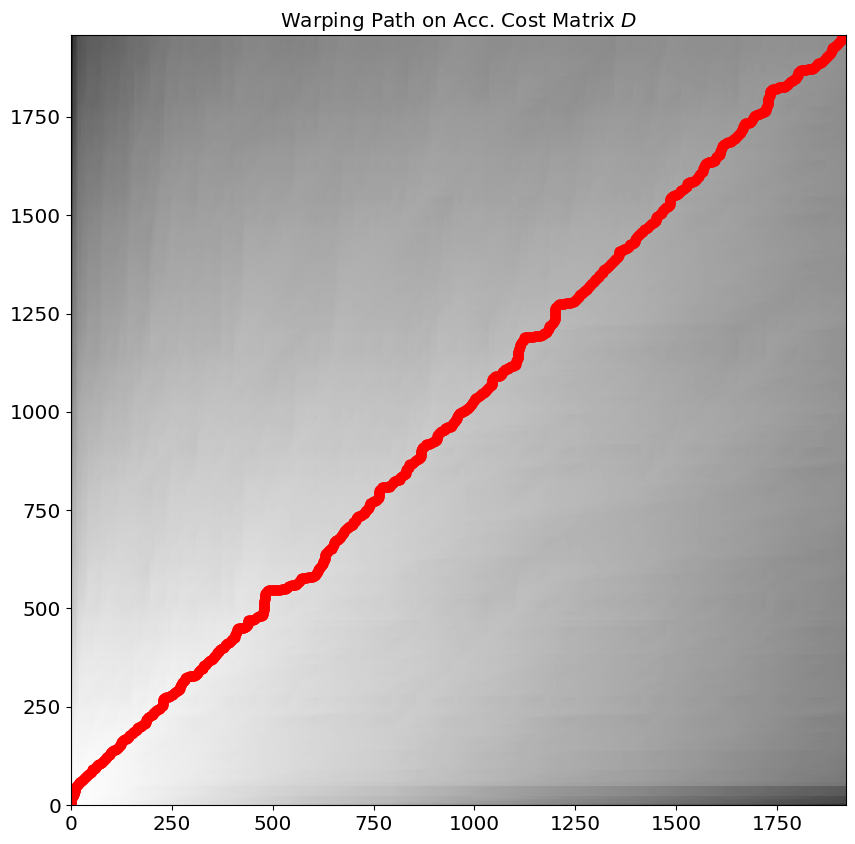

In [48]:
import librosa
import librosa.display

D, wp = librosa.sequence.dtw(X=chroma_stft1, Y=chroma_stft2, metric='cosine')
wp_s = np.asarray(wp) * hop_size1 / n_fft1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
#librosa.display.specshow(D, x_axis='time', y_axis='time',
 #                        cmap='gray_r', hop_length=hop_size1)
imax = ax.imshow(D, cmap=plt.get_cmap('gray_r'),
                 origin='lower', interpolation='nearest', aspect='auto')
ax.plot(wp_s[:, 1], wp_s[:, 0], marker='o', color='r')
plt.title('Warping Path on Acc. Cost Matrix $D$')
#plt.colorbar()

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, '')]

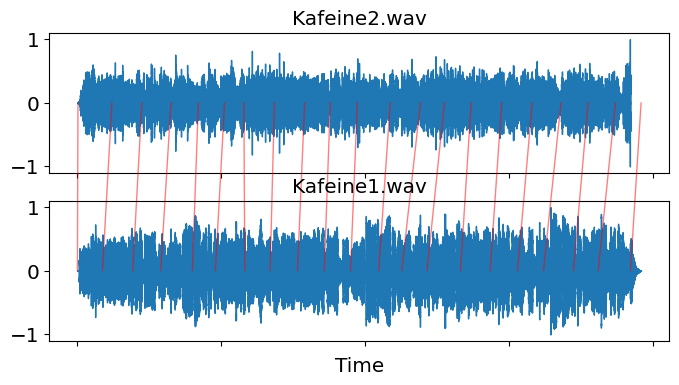

In [49]:
#plt.colorbar()
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import *

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 4))

# Plot x_2
librosa.display.waveshow(samples1, sr=n_fft1, ax=ax2)
ax2.set(title='Kafeine1.wav')

# Plot x_1
librosa.display.waveshow(samples2, sr=n_fft2, ax=ax1)
ax1.set(title='Kafeine2.wav')
ax1.label_outer()

n_arrows = 20
for tp1, tp2 in wp_s[::len(wp_s) // n_arrows]:
    # Create a connection patch between the aligned time points
    # in each subplot
    con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='-',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)
plt.gca().axes.xaxis.set_ticklabels([])

In [50]:
def get_samples_and_rate(sound):
    # Import the audio file
    starting_time = 0
    duration = 15 #s
    scaling_factor = 1.0 / sound.max #normalization
    # Get sample as a numpy array
    samples = np.array(sound[starting_time*1000:(starting_time+duration)*1000].get_array_of_samples())*scaling_factor
    sample_rate = sound.frame_rate
    return samples, sample_rate

sound = AudioSegment.from_file("cretansyrtos.wav", format="wav")
sound = sound.split_to_mono()[0]
samples1, sample_rate1 = get_samples_and_rate(sound)

sound = AudioSegment.from_file("cymbal1_2k_100bpm.wav", format="wav")
sound = sound.split_to_mono()[0]
samples2, sample_rate2 = get_samples_and_rate(sound)

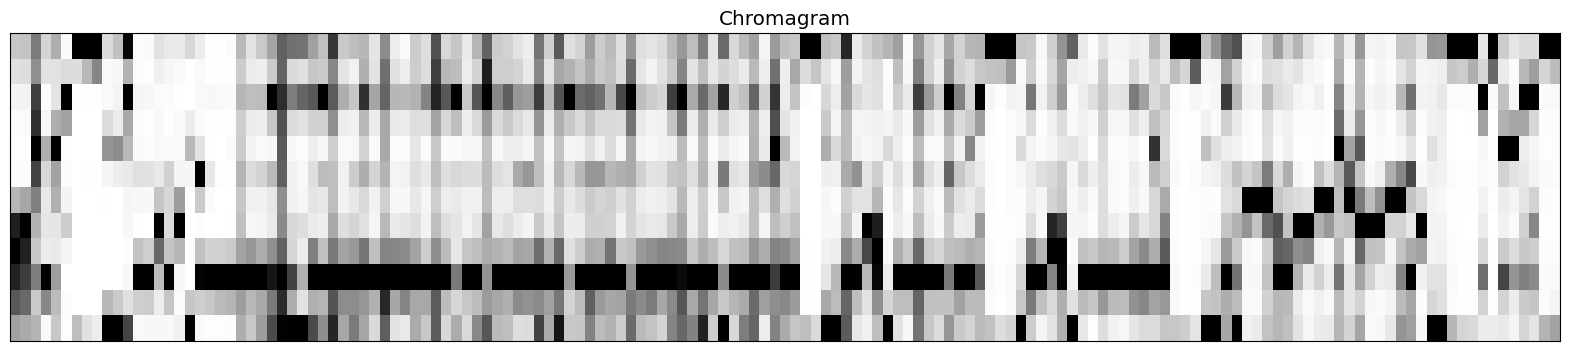

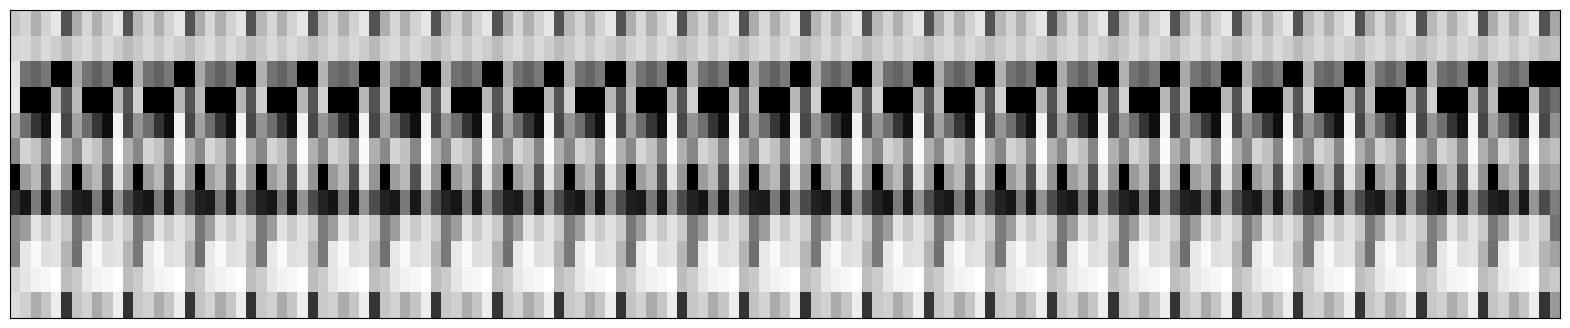

In [51]:
#plt.colorbar()
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import *
n_fft1 = int(0.15*sample_rate1)
n_fft2 = int(0.15*sample_rate2)
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(8, 4))

# Plot x_2
librosa.display.waveshow(samples1, sr=n_fft1, ax=ax2)
ax2.set(title='cretansyrtos.wav')

# Plot x_1
librosa.display.waveshow(samples2, sr=n_fft2, ax=ax1)
ax1.set(title='cymbal1_2k_100bpm.wav')
ax1.set_xlabel('Time(s)')
ax1.label_outer()

n_arrows = 20
for tp1, tp2 in wp_s[::len(wp_s) // n_arrows]:
    # Create a connection patch between the aligned time points
    # in each subplot
    con = ConnectionPatch(xyA=(tp1, 0), xyB=(tp2, 0),
                          axesA=ax1, axesB=ax2,
                          coordsA='data', coordsB='data',
                          color='r', linestyle='-',
                          alpha=0.5)
    con.set_in_layout(False)  # This is needed to preserve layout
    ax2.add_artist(con)
plt.gca().axes.xaxis.set_ticklabels([])

As can be clearly seen, the audio files differ in such a way that it makes basically no sense to even want to achieve any form of alignment between them.